In [1]:
import pandas as pd

# Step 1: Load the data without headers
df = pd.read_csv("C:\\Job\\NASAp\\data\\train_FD001.txt", sep=r"\s+", header=None)


# Step 2: Define correct column names based on CMAPSS format
columns = ['unit', 'time', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]  # sensors 1 to 21
# Confirm length
assert len(columns) == df.shape[1], f"Expected {len(columns)} columns but got {df.shape[1]}"

df.columns = columns


In [2]:
print(df.columns.tolist())

['unit', 'time', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


In [3]:
import pandas as pd

df = pd.read_csv('../data/train_FD001_cleaned.csv')
df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,RUL
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,21.61,554.36,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,21.61,553.75,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,21.61,554.26,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,21.61,554.45,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,21.61,554.00,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [4]:
sensor_cols = [col for col in df.columns if 'sensor' in col]


In [5]:
import numpy as np

engine_ids = df['engine_id'].unique()
np.random.seed(42)
np.random.shuffle(engine_ids)

split_idx = int(len(engine_ids) * 0.8)
train_ids = engine_ids[:split_idx]
test_ids = engine_ids[split_idx:]

df_train = df[df['engine_id'].isin(train_ids)].reset_index(drop=True)
df_test = df[df['engine_id'].isin(test_ids)].reset_index(drop=True)


In [6]:
rolling_window = 5

for col in sensor_cols:
    df_train[f'{col}_rollmean'] = df_train.groupby('engine_id')[col].transform(lambda x: x.rolling(rolling_window).mean())
    df_test[f'{col}_rollmean'] = df_test.groupby('engine_id')[col].transform(lambda x: x.rolling(rolling_window).mean())


In [7]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

feature_cols = [col for col in df_train.columns if 'sensor' in col]

X_train = df_train[feature_cols]
y_train = df_train['RUL']

X_test = df_test[feature_cols]
y_test = df_test['RUL']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_rf_pred = rf_model.predict(X_test)


Engine-wise RF MAE: 32.16
Engine-wise RF RMSE: 44.63


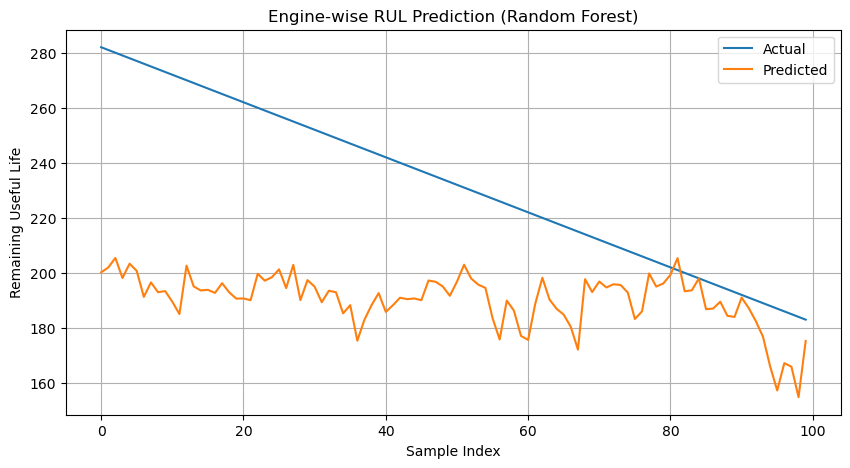

In [9]:
mae = mean_absolute_error(y_test, y_rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))

print(f"Engine-wise RF MAE: {mae:.2f}")
print(f"Engine-wise RF RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_rf_pred[:100], label='Predicted')
plt.title('Engine-wise RUL Prediction (Random Forest)')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
print(df.shape)  # Confirm data loaded
print(df_train.shape, df_test.shape)  # Check split sizes
print(sensor_cols)  # Check retained sensors
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")  # Final results


(20631, 24)
(16020, 42) (4211, 42)
['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_16', 'sensor_measurement_17', 'sensor_measurement_18', 'sensor_measurement_19', 'sensor_measurement_20', 'sensor_measurement_21']
MAE: 32.16, RMSE: 44.63


In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/train_FD001_cleaned.csv')
sensor_cols = [col for col in df.columns if 'sensor' in col]


In [12]:
engine_ids = df['engine_id'].unique()
np.random.seed(42)
np.random.shuffle(engine_ids)

split_idx = int(len(engine_ids) * 0.8)
train_ids = engine_ids[:split_idx]
test_ids = engine_ids[split_idx:]

df_train = df[df['engine_id'].isin(train_ids)].reset_index(drop=True)
df_test = df[df['engine_id'].isin(test_ids)].reset_index(drop=True)


In [13]:
for col in sensor_cols:
    df_train[f'{col}_delta'] = df_train.groupby('engine_id')[col].diff()
    df_test[f'{col}_delta'] = df_test.groupby('engine_id')[col].diff()


In [14]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [15]:
feature_cols = [col for col in df_train.columns if 'sensor' in col]

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

X_train = df_train[feature_cols]
y_train = df_train['RUL']

X_test = df_test[feature_cols]
y_test = df_test['RUL']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_rf_pred = rf_model.predict(X_test)

In [17]:
mae = mean_absolute_error(y_test, y_rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_rf_pred))

print(f"Delta + Rolling MAE: {mae:.2f}")
print(f"Delta + Rolling RMSE: {rmse:.2f}")

Delta + Rolling MAE: 32.90
Delta + Rolling RMSE: 44.81


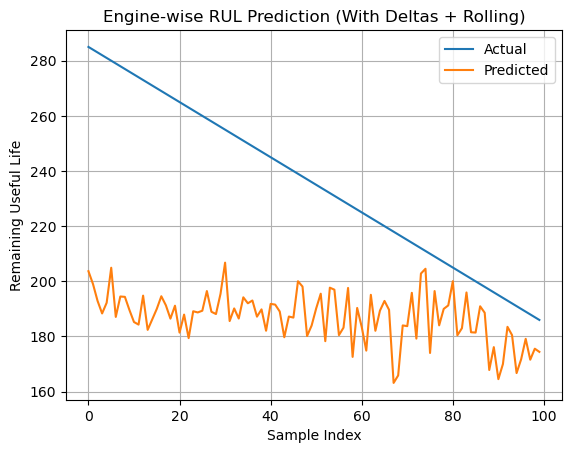

In [18]:
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_rf_pred[:100], label='Predicted')
plt.title('Engine-wise RUL Prediction (With Deltas + Rolling)')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print("Columns in df:")
print(df.columns.tolist())

print("\nSample data:")
print(df[['sensor_measurement_2']].head(10))

print("\nCheck if 'sensor_measurement_2_ma' exists:")
print('sensor_measurement_2_ma' in df.columns)

print("\nAny nulls in sensor_measurement_2?")
print(df['sensor_measurement_2'].isnull().sum())


Columns in df:
['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_16', 'sensor_measurement_17', 'sensor_measurement_18', 'sensor_measurement_19', 'sensor_measurement_20', 'sensor_measurement_21', 'RUL']

Sample data:
   sensor_measurement_2
0                641.82
1                642.15
2                642.35
3                642.35
4                642.37
5                642.10
6                642.48
7                642.56
8                642.12
9                641.71

Check if 'sensor_measurement_2_ma' exists:
False

Any nulls in sensor_measurement_2?
0


In [20]:
df['sensor_measurement_2_ma'] = df['sensor_measurement_2'].rolling(window=5).mean()
df['sensor_measurement_2_ema'] = df['sensor_measurement_2'].ewm(span=5, adjust=False).mean()

In [21]:
df['sensor_measurement_2_diff'] = df['sensor_measurement_2'].diff()

In [22]:
# Use consistent naming based on your updated style
sensor_col = 'sensor_measurement_2'

df['sensor_measurement_2_ma'] = df[sensor_col].rolling(window=5, min_periods=1).mean()
df['sensor_measurement_2_ema'] = df[sensor_col].ewm(span=5, adjust=False).mean()
df['sensor_measurement_2_diff'] = df[sensor_col].diff()

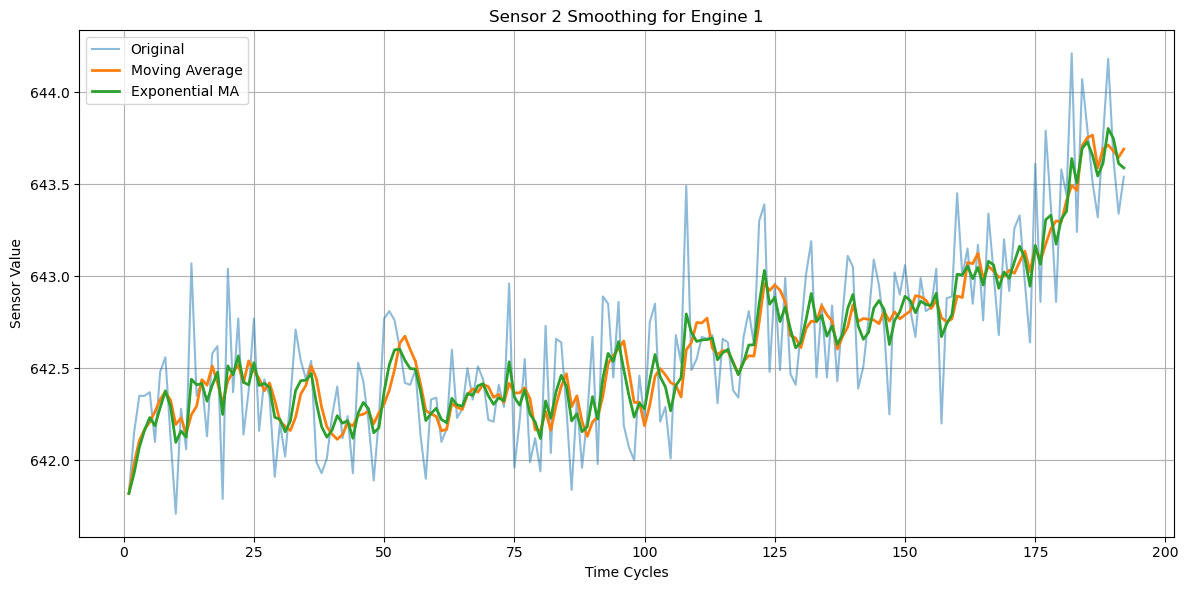

In [23]:
import matplotlib.pyplot as plt

unit_id = 1
df_unit = df[df['engine_id'] == unit_id]

plt.figure(figsize=(12, 6))
plt.plot(df_unit['cycle'], df_unit['sensor_measurement_2'], label='Original', alpha=0.5)
plt.plot(df_unit['cycle'], df_unit['sensor_measurement_2_ma'], label='Moving Average', linewidth=2)
plt.plot(df_unit['cycle'], df_unit['sensor_measurement_2_ema'], label='Exponential MA', linewidth=2)
plt.title(f'Sensor 2 Smoothing for Engine {unit_id}')
plt.xlabel('Time Cycles')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
from scipy.stats import zscore

# Calculate z-score for the sensor column
df['sensor_measurement_2_z'] = zscore(df['sensor_measurement_2'])

# Flag anomalies where z-score > 3 or < -3
df['anomaly'] = (df['sensor_measurement_2_z'].abs() > 3).astype(int)


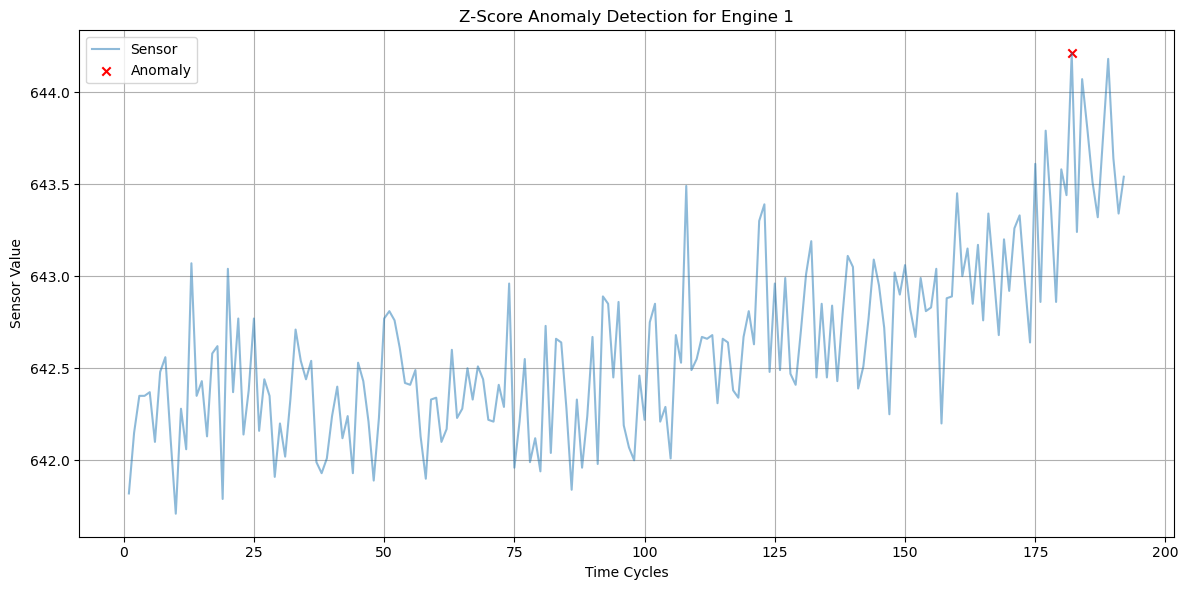

In [25]:
unit_id = 1
df_unit = df[df['engine_id'] == unit_id]

plt.figure(figsize=(12, 6))
plt.plot(df_unit['cycle'], df_unit['sensor_measurement_2'], label='Sensor', alpha=0.5)
plt.scatter(
    df_unit[df_unit['anomaly'] == 1]['cycle'],
    df_unit[df_unit['anomaly'] == 1]['sensor_measurement_2'],
    color='red', marker='x', label='Anomaly'
)
plt.title(f'Z-Score Anomaly Detection for Engine {unit_id}')
plt.xlabel('Time Cycles')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Drop NaNs from diff column
features = ['sensor_measurement_2', 'sensor_measurement_2_ma', 'sensor_measurement_2_diff']
df_model = df.dropna(subset=features + ['anomaly'])

X = df_model[features]
y = df_model['anomaly']


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4120    0]
 [   0    6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4120
           1       1.00      1.00      1.00         6

    accuracy                           1.00      4126
   macro avg       1.00      1.00      1.00      4126
weighted avg       1.00      1.00      1.00      4126



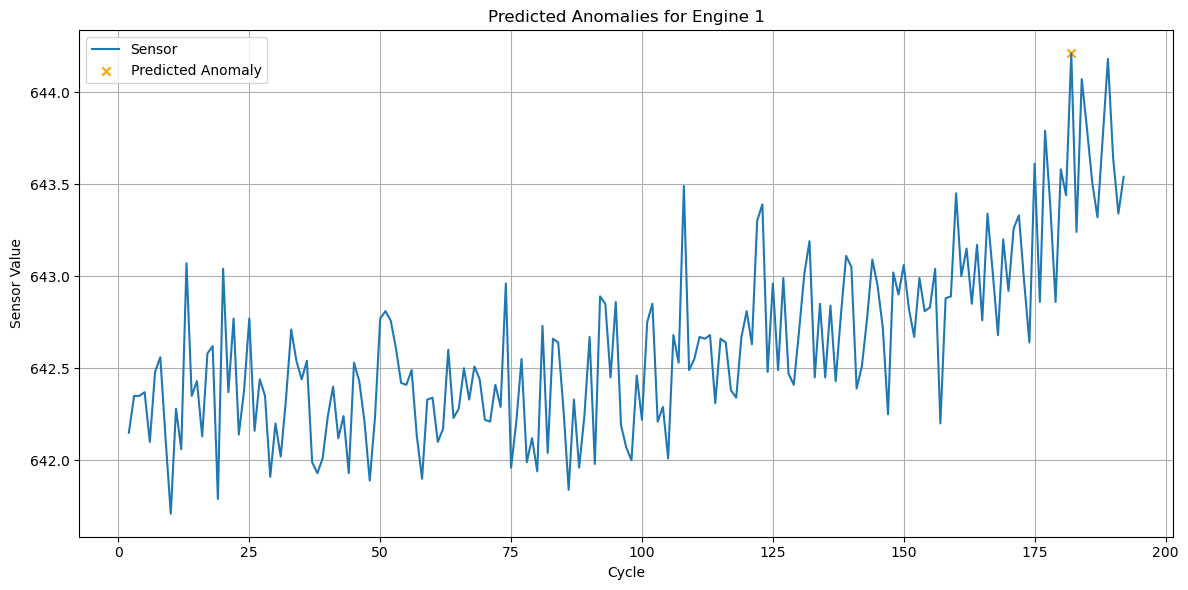

In [29]:
# Safe version that avoids SettingWithCopyWarning
df_model = df.dropna(subset=features + ['anomaly']).copy()

# Now it's safe to assign new columns
df_model['predicted_anomaly'] = clf.predict(df_model[features])

df_unit = df_model[df_model['engine_id'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(df_unit['cycle'], df_unit['sensor_measurement_2'], label='Sensor')
plt.scatter(df_unit[df_unit['predicted_anomaly'] == 1]['cycle'],
            df_unit[df_unit['predicted_anomaly'] == 1]['sensor_measurement_2'],
            color='orange', label='Predicted Anomaly', marker='x')
plt.title('Predicted Anomalies for Engine 1')
plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
df.to_csv("nasa_processed.csv", index=False)
